### Demonstration of triangle slicing

Here are some Python based functions for slicing 
sets of triangles given in an STL file relative to 
different tool shapes.  

A "barmesh" is an efficient way of encoding a continuous 
mesh of triangles using forward-right and back-left pointers 
from each edge that makes the triangles trivial to infer.


```
        _____NF
            /|
           ^ |
          /  |BFR
    |    /-> |
    | <-/    |
 BBL|  /     |
    | / 
    |/___
   NB
```

In [1]:
import time
time.process_time()

1.314062935

In [2]:
# quick access to the library (I know this is not done properly)
import sys
sys.path.append("..")

In [3]:
# load the triangles into the efficient encoding structure 
# (there is a numpy based version of this, which we should use in future)
from tribarmes import TriangleBarMesh
fname = "../stlsamples/frameguide.stl"
tbm = TriangleBarMesh(fname)

/tmp/nix-shell.h7PFCy/ipykernel_416553/882097596.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


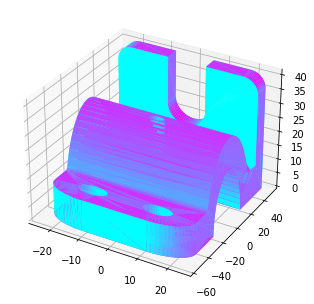

In [4]:
# Quick and dirty plot of this triangle mesh in 3D 
%matplotlib inline

from basicgeo import P3

from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

fig = plt.figure()
axes = mplot3d.Axes3D(fig)

vs = tbm.GetBarMeshTriangles()
cs = mplot3d.art3d.Poly3DCollection(vs)

# need to shade the triangles according to normal vectors
cm = plt.get_cmap('cool')
def col(t):
    n = P3.ZNorm(P3.Cross(t[1]-t[0], t[2]-t[0]))
    if n[2] < 0:
        n = -n
    return cm(n[2]*0.8 + n[0]*0.6)
cs.set_facecolor([col(t)  for t in vs])

axes.auto_scale_xyz([t[0][0]  for t in vs], [t[0][1]  for t in vs], [t[0][2]  for t in vs])
axes.add_collection3d(cs)
plt.show()

In [5]:
# This builds the initial 2D mesh which will be used for the basis of the 
# slicing of the STL shape above
from basicgeo import P2, P3, Partition1, Along
import barmesh

rad = 2.5
rex = rad + 2.5
xpart = Partition1(tbm.xlo-rex, tbm.xhi+rex, 19)
ypart = Partition1(tbm.ylo-rex, tbm.yhi+rex, 17)
zlevel = Along(0.1, tbm.zlo, tbm.zhi)

bm = barmesh.BarMesh()
bm.BuildRectBarMesh(xpart, ypart, zlevel)


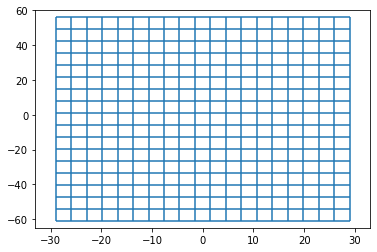

In [6]:
# show the mesh as just a regular rectangular array of line segments

from matplotlib.collections import LineCollection
segments = [[(bar.nodeback.p[0], bar.nodeback.p[1]), (bar.nodefore.p[0], bar.nodefore.p[1])]  for bar in bm.bars  if not bar.bbardeleted ]
lc = LineCollection(segments)

plt.gca().add_collection(lc)
rex2 = rex + 4
plt.xlim(tbm.xlo-rex2, tbm.xhi+rex2)
plt.ylim(tbm.ylo-rex2, tbm.yhi+rex2)
plt.show()

In [7]:
import implicitareaballoffset
iaoffset = implicitareaballoffset.ImplicitAreaBallOffset(tbm)


make triangle boxing at 0.4800000000000001


In [8]:
# Here we actually make the slice of the triangle mesh by inserting mid-points 
# into the segments and adding more joining segments where needed to model the
# contours to tolerance
from barmeshslicer import BarMeshSlicer

rd2 = max(xpart.vs[1]-xpart.vs[0], ypart.vs[1]-ypart.vs[0], rad*1.5) + 0.1
bms = BarMeshSlicer(bm, iaoffset, rd=rad, rd2=rd2, contourdotdiff=0.95, contourdelta=0.05, lamendgap=0.001)
bms.fullmakeslice()


nsegs: 402 bad: 0 working: 0
979 [141, 107, 80, 40, 0, 100, 95, 72, 60, 10, 39, 52, 50, 15, 8, 10, 10, 30, 10, 5, 10, 5, 5, 10, 0, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0]


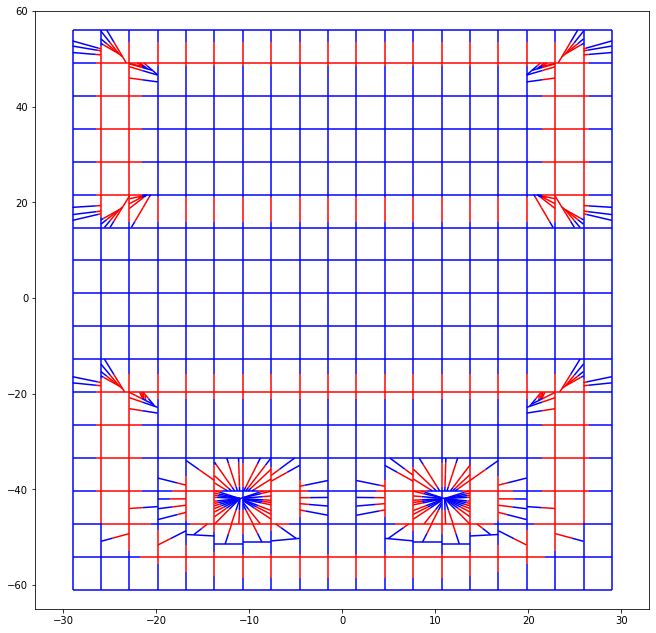

In [9]:
# Plot the in and out parts of each segments in red and blue
plt.figure(figsize=(11,11))

segmentswithin = [ ]
segmentsbeyond = [ ]
for bar in bm.bars:
    if not bar.bbardeleted:
        p0within, p1within = None, None
        p0beyond, p1beyond = None, None
        if bar.nodeback.pointzone.izone == barmesh.PZ_WITHIN_R and bar.nodefore.pointzone.izone == barmesh.PZ_WITHIN_R:
            p0within, p1within = bar.nodeback.p, bar.nodefore.p
        elif bar.nodeback.pointzone.izone == barmesh.PZ_BEYOND_R and bar.nodefore.pointzone.izone == barmesh.PZ_BEYOND_R:
            p0beyond, p1beyond = bar.nodeback.p, bar.nodefore.p
        elif bar.nodeback.pointzone.izone == barmesh.PZ_WITHIN_R and bar.nodefore.pointzone.izone == barmesh.PZ_BEYOND_R:
            p0within, p1within = bar.nodeback.p, bar.nodemid.p
            p0beyond, p1beyond = bar.nodemid.p, bar.nodefore.p
        elif bar.nodeback.pointzone.izone == barmesh.PZ_BEYOND_R and bar.nodefore.pointzone.izone == barmesh.PZ_WITHIN_R:
            p0beyond, p1beyond = bar.nodeback.p, bar.nodemid.p
            p0within, p1within = bar.nodemid.p, bar.nodefore.p
            
        if p0within:
            segmentswithin.append([(p0within[0], p0within[1]), (p1within[0], p1within[1])])
        if p0beyond:
            segmentsbeyond.append([(p0beyond[0], p0beyond[1]), (p1beyond[0], p1beyond[1])])

lc = LineCollection(segmentswithin, color="red")
plt.gca().add_collection(lc)
lc = LineCollection(segmentsbeyond, color="blue")
plt.gca().add_collection(lc)

rex2 = rex + 4
plt.xlim(tbm.xlo-rex2, tbm.xhi+rex2)
plt.ylim(tbm.ylo-rex2, tbm.yhi+rex2)
plt.show()



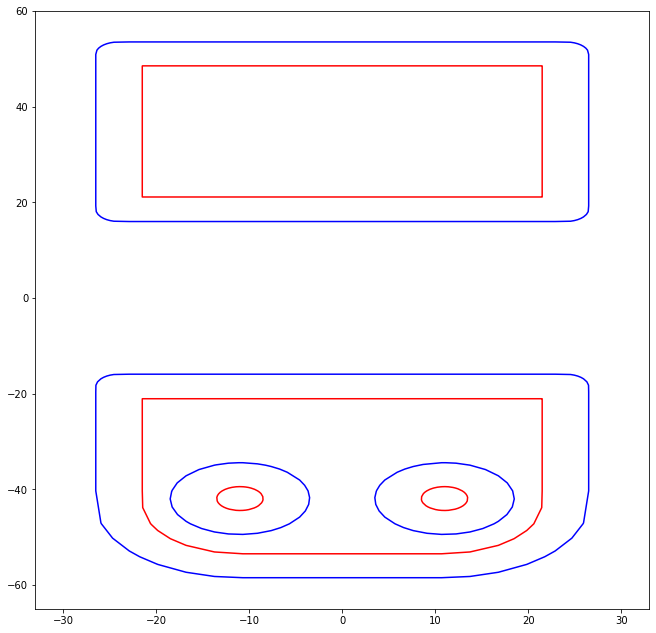

In [10]:
# Now extract the contours by following the round the cells keeping the WITHIN 
# and BEYOND sides on one side of a series of nodemids

from mainfunctions import BarMeshContoursF, NestContours
conts, topbars = BarMeshContoursF(bm, barmesh.PZ_BEYOND_R)

contnest = NestContours(topbars, barmesh.PZ_BEYOND_R)

mconts = dict((topbar.midcontournumber, cont)  for cont, topbar in zip(conts, topbars))

cnswithin = [cn  for cn, (izone, outxn, innlist) in contnest.items()  if izone == barmesh.PZ_WITHIN_R]
cnsbeyond = [cn  for cn, (izone, outxn, innlist) in contnest.items()  if izone == barmesh.PZ_BEYOND_R]

plt.figure(figsize=(11,11))

lc = LineCollection([[(p[0], p[1]) for p in mconts[cn]]  for cn in cnswithin], color="red")
plt.gca().add_collection(lc)
lc = LineCollection([[(p[0], p[1]) for p in mconts[cn]]  for cn in cnsbeyond], color="blue")
plt.gca().add_collection(lc)


rex2 = rex + 4
plt.xlim(tbm.xlo-rex2, tbm.xhi+rex2)
plt.ylim(tbm.ylo-rex2, tbm.yhi+rex2)
plt.show()


In [11]:

class F:
    def __init__(self, V):
        self.V = V
class G(F):
    def __init__(self, q):
        super().__init__(88)
        self.q = q

g = G(9)

In [7]:
g.__dict__

{'V': 88, 'q': 9}